# <center>Model Interpretability on Random Forest using SHAP</center>

## Table of Contents

1. [Problem Statement](#section1)<br><br>
2. [Importing Packages](#section2)<br><br>
3. [Loading Data](#section3)
  - 3.1 [Description of the Dataset](#section301)<br><br>
4. [Data train/test split](#section4)<br><br>
5. [Random Forest Model](#section5)
  - 5.1 [Random Forest in scikit-learn](#section501)<br><br>   
  - 5.2 [Feature Importances](#section502)<br><br>
  - 5.3 [Using the Model for Prediction](#section503)<br><br>
6. [Model Evaluation](#section6)
   - 6.1 [R-Squared Value](#section601)<br><br>
7. [Model Interpretability using SHAP](#section7)   
  - 7.1 [Explain predictions](#section701)<br><br>
  - 7.2 [Visualize a single prediction](#section702)<br><br>
  - 7.3 [Visualize many predictions](#section703)<br><br>
  - 7.4 [SHAP Dependence Plots](#section704)<br><br>
  - 7.5 [SHAP Summary Plot](#section705)<br><br>
  - 7.6 [Bar chart of Mean Importance](#section706)<br>

<a id=section1></a>
## 1. Problem Statement


- We have often found that **Machine Learning (ML)** algorithms capable of capturing **structural non-linearities** in training data - models that are sometimes referred to as **'black box' (e.g. Random Forests, Deep Neural Networks, etc.)** - perform far **better at prediction** than their **linear counterparts (e.g. Generalized Linear Models)**. 


- They are, however, much **harder to interpret** - in fact, quite often it is **not possible to gain any insight into why a particular prediction has been produced**, when given an **instance of input data (i.e. the model features)**. 


- Consequently, it has **not been possible to use 'black box' ML algorithms** in situations where clients have sought **cause-and-effect explanations for model predictions**, with end-results being that sub-optimal predictive models have been used in their place, as their explanatory power has been more valuable, in relative terms.


- The **problem with model explainability** is that it’s **very hard to define a model’s decision boundary in human understandable manner**. 


- **SHAP (SHapley Additive exPlanations)** is a unified approach to **explain the output of any machine learning model**.

<br>
<img src="../../images/shap.png" width="700" height="400"/> <br><br>


- We will use **SHAP** to **interpret** our **RandomForest model**.

---

<a id=section2></a>
## 2. Importing Packages

In [ ]:
# Install SHAP using the following command.

!pip install shap

In [1]:
import numpy as np
np.set_printoptions(precision=4)                    # To display values only upto four decimal places. 

import pandas as pd
pd.set_option('mode.chained_assignment', None)      # To suppress pandas warnings.
pd.set_option('display.max_colwidth', -1)           # To display all the data in the columns.
pd.options.display.max_columns = 40                 # To display all the columns. (Set the value to a high number)

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')                  # To apply seaborn whitegrid style to the plots.
plt.rc('figure', figsize=(10, 8))                   # Set the default figure size of plots.
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')                   # To suppress all the warnings in the notebook.

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

---

<a id=section3></a>
## 3. Loading Data

In [2]:
df = pd.read_csv('../../data/Boston.csv')
df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


<a id=section301></a>
### 3.1 Description of the Dataset

- This dataset contains information on **Housing Values in Suburbs of Boston**.


- The column **medv** is the **target variable**. It is the **median** value of **owner-occupied homes in $1000s**.

| Column Name                      | Description                                                                              |
| ---------------------------------|:----------------------------------------------------------------------------------------:| 
| crim                             | Per capita crime rate by town.                                                           |
| zn                               | Proportion of residential land zoned for lots over 25,000 sq.ft.                         |
| indus                            | Proportion of non-retail business acres per town.                                        |
| chas                             | Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).                   |
| nox                              | Nitrogen oxides concentration (parts per 10 million).                                    |
| rm                               | Average number of rooms per dwelling.                                                    |
| age                              | Proportion of owner-occupied units built prior to 1940.                                  |
| dis                              | Weighted mean of distances to five Boston employment centres.                            |
| rad                              | Index of accessibility to radial highways.                                               |
| tax                              | Full-value property-tax rate per 10,000 dollars.                                         |
| ptratio                          | Pupil-teacher ratio by town.                                                             |
| black                            | 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town.                          |
| lstat                            | Lower status of the population (percent).                                                |
| medv                             | Target, median value of owner-occupied homes in $1000s.                                  |

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
crim       506 non-null float64
zn         506 non-null float64
indus      506 non-null float64
chas       506 non-null int64
nox        506 non-null float64
rm         506 non-null float64
age        506 non-null float64
dis        506 non-null float64
rad        506 non-null int64
tax        506 non-null float64
ptratio    506 non-null float64
black      506 non-null float64
lstat      506 non-null float64
medv       506 non-null float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


In [4]:
df.describe()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677082,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


---

<a id=section4></a>
## 4. Data train/test split

- Now that the entire **data** is of **numeric datatype**, lets begin our modelling process.


- Firstly, **splitting** the complete **dataset** into **training** and **testing** datasets.

In [5]:
df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [6]:
X = df.iloc[:, :-1]
X.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33


In [7]:
y = df.iloc[:, -1]
y.head()

0    24.0
1    21.6
2    34.7
3    33.4
4    36.2
Name: medv, dtype: float64

In [8]:
# Using scikit-learn's train_test_split function to split the dataset into train and test sets.
# 80% of the data will be in the train set and 20% in the test set, as specified by test_size=0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Checking the shapes of all the training and test sets for the dependent and independent features.

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(404, 13)
(404,)
(102, 13)
(102,)


---

<a id=section5></a>
## 5.  Random Forest Model

<a id=section501></a>
### 5.1  Random Forest with Scikit-Learn

In [12]:
# Creating a Random Forest Regressor.

regressor_rf = RandomForestRegressor(n_estimators=200, random_state=0, oob_score=True, n_jobs=-1)

In [13]:
# Fitting the model on the dataset.

regressor_rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
                      oob_score=True, random_state=0, verbose=0,
                      warm_start=False)

In [14]:
regressor_rf.oob_score_

0.8375610635726134

- From the **OOB score** we can see how our model's gonna perform against the **test set or new** samples.

---

<a id=section502></a>
### 5.2  Feature Importances

In [15]:
X_train.columns

Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'black', 'lstat'],
      dtype='object')

In [16]:
# Checking the feature importances of various features.
# Sorting the importances by descending order (lowest importance at the bottom).

for score, name in sorted(zip(regressor_rf.feature_importances_, X_train.columns), reverse=True):
    print('Feature importance of', name, ':', score*100, '%')

Feature importance of rm : 48.652000069343806 %
Feature importance of lstat : 32.62519467239989 %
Feature importance of dis : 5.723002765414628 %
Feature importance of crim : 3.688078587412392 %
Feature importance of nox : 1.7565510857613313 %
Feature importance of ptratio : 1.7390709979839825 %
Feature importance of tax : 1.662967097458929 %
Feature importance of age : 1.470551943168394 %
Feature importance of black : 1.3621235473729538 %
Feature importance of indus : 0.6664660162044432 %
Feature importance of rad : 0.3849848939558503 %
Feature importance of zn : 0.1498360991801689 %
Feature importance of chas : 0.11917222434323611 %


---

<a id=section503></a>
### 5.3 Using the Model for Prediction

In [17]:
# Making predictions on the training set.

y_pred_train = regressor_rf.predict(X_train)
y_pred_train[:10]

array([12.511 , 19.9775, 19.77  , 13.258 , 18.5805, 24.453 , 20.89  ,
       23.869 ,  8.595 , 23.5375])

In [18]:
# Making predictions on test set.

y_pred_test = regressor_rf.predict(X_test)
y_pred_test[:10]

array([22.57  , 31.5625, 17.109 , 23.243 , 16.7635, 21.303 , 19.24  ,
       15.6195, 21.429 , 20.964 ])

---

<a id=section6></a>
## 6. Model Evaluation

**Error** is the deviation of the values predicted by the model with the true values.

<a id=section601></a>
### 6.1 R-Squared Value

In [19]:
# R-Squared Value on the training set.

print('R-Squared Value for train data is:', r2_score(y_train, y_pred_train))

R-Squared Value for train data is: 0.9774359941752926


In [20]:
# R-Squared Value on the test set.

print('R-Squared Value for test data is:', r2_score(y_test, y_pred_test))

R-Squared Value for test data is: 0.8798665934496468


- We get an **R-Squared Value** of **97.74%** on our train set and an **R-Squared Value** of **87.98%** on our test set.

<a id=section7></a>
## 7. Model Interpretability using SHAP


- **SHAP (SHapley Additive exPlanations)** is a unified approach to **explain the output of any machine learning model**. 


- **SHAP connects game theory with local explanations**, uniting several previous methods and representing the only possible consistent and locally accurate additive feature attribution method based on expectations. 

In [21]:
import shap

In [22]:
# Load JS visualization code to notebook

shap.initjs()

<a id=section701></a>
### 7.1 Explain predictions

In [23]:
# Explain the model's predictions using SHAP values 

explainer = shap.TreeExplainer(regressor_rf)

In [25]:
shap_values = explainer.shap_values(X_train.values)

In [27]:
shap_values.shape

(404, 13)

<a id=section702></a>
### 7.2 Visualize a single prediction

In [23]:
# Visualize the first prediction's explanation

shap.force_plot(explainer.expected_value, shap_values[0, :], X_train.iloc[0, :])

- The above explanation shows **features** each contributing to **push the model output** from the **base value** (the **average model output over the training dataset** we passed) **to the model output**. 


- **Features pushing the prediction higher** are shown in **red**, those **pushing the prediction lower are in blue**.


- The **values** written after each **feature** is their **actual value** in the **data** for this **particular sample (row)**.

<a id=section703></a>
### 7.3 Visualize many predictions

- If we take **many explanations** such as the one shown above, **rotate them 90 degrees**, and then **stack them horizontally**, we can see **explanations for an entire dataset**.

In [24]:
# Visualize the training set predictions 

shap.force_plot(explainer.expected_value, shap_values, X_train)

<a id=section704></a>
### 7.4 SHAP Dependence Plots

- **SHAP dependence plots** show the **effect of a single feature across the whole dataset**. 


- They **plot a feature's value vs. the SHAP value** of that feature **across many samples**.


- The **vertical dispersion** of **SHAP values at a single feature value** is driven by **interaction effects**, and **another feature** is chosen for **coloring** to **highlight possible interactions**.

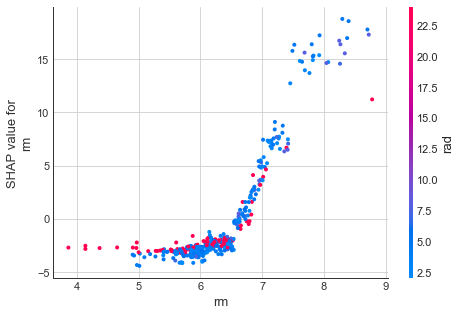

In [25]:
# Create a SHAP dependence plot to show the effect of a single feature across the whole dataset

shap.dependence_plot('rm', shap_values, X_train)

- Since **SHAP values** represent a **feature's responsibility for a change in the model output**, the plot above represents the **change in predicted house price** as **rm** (the average number of rooms per house in an area) **changes**. 
<br><br>
  - **Vertical dispersion** at a single value of **rm** represents **interaction effects** with **other features**. 
<br><br> 
  - To help **reveal** these **interactions dependence_plot automatically selects another feature for coloring**. 
<br><br> 
  - In this case **coloring** by **rad** (index of accessibility to radial highways) **highlights** that the **average number of rooms per house** has **less impact on home price for areas** with a **high rad** value.

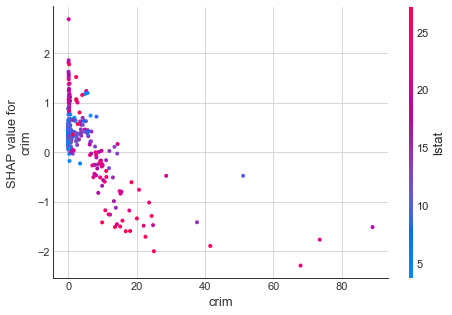

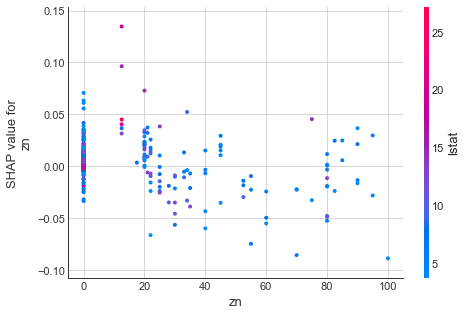

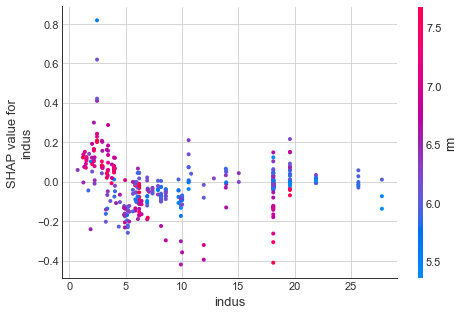

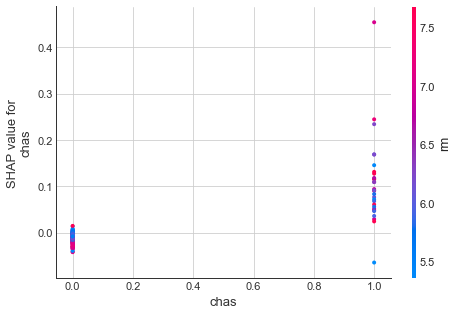

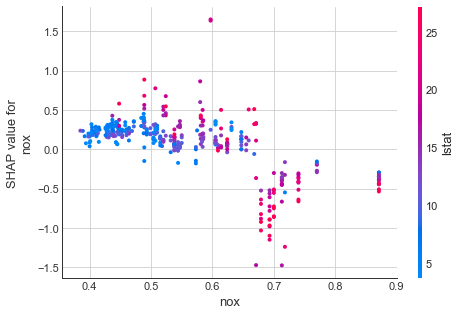

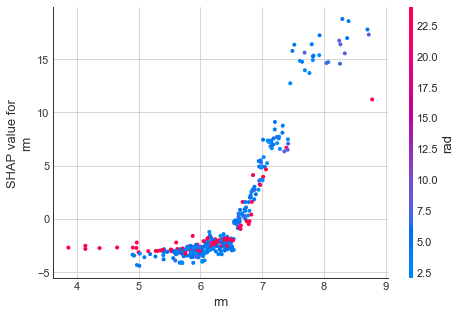

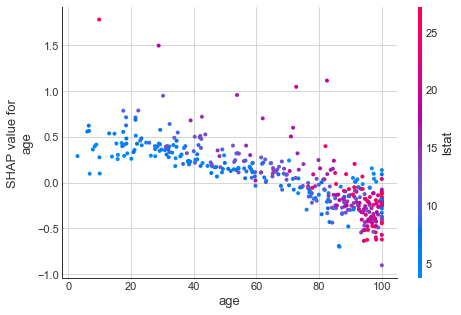

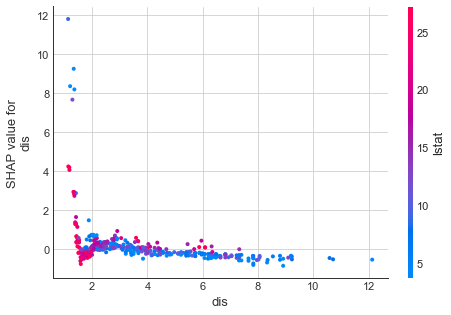

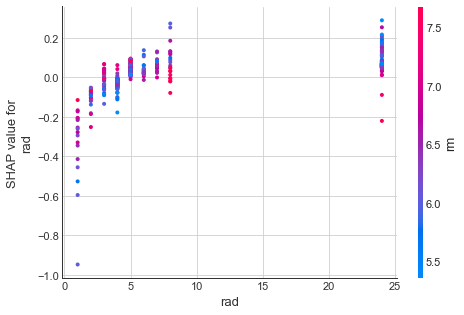

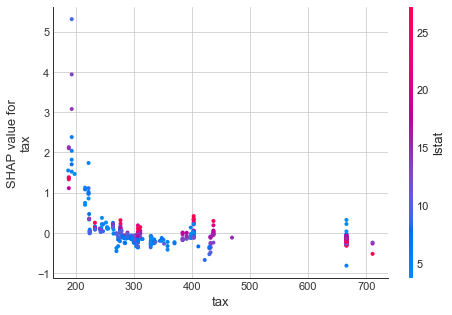

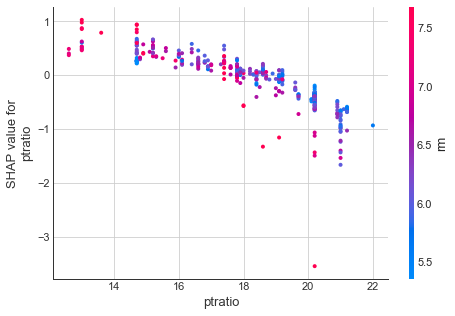

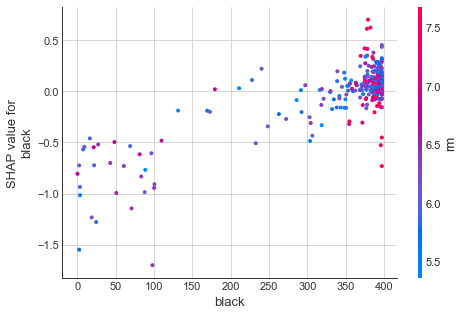

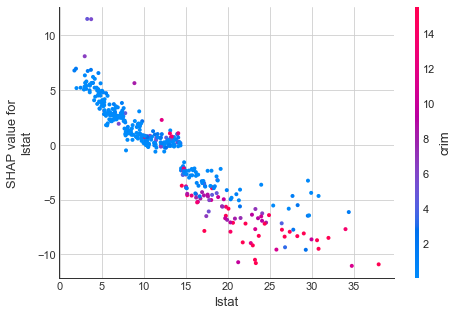

In [26]:
for name in X_train.columns:
    shap.dependence_plot(name, shap_values, X_train)

- This shows us the method for **Plotting** the **Dependence Plots** for **each feature** in the dataset in a few lines of code.

<a id=section705></a>
### 7.5 SHAP Summary Plot

- To get an overview of **which features** are **most important for a model** we can **plot** the **SHAP values** of **every feature** for **every sample**. 


- We use a **density scatter plot** of **SHAP values** for **each feature to identify** how much **impact each feature has on the model output** for **individuals** in the **validation dataset**. 


- **Features** are **sorted** by the **sum of the SHAP value magnitudes** across all samples. 


- Note that when the **scatter points don't fit on a line** they **pile up to show density**, and the **color of each point represents** the **feature value of that individual**.

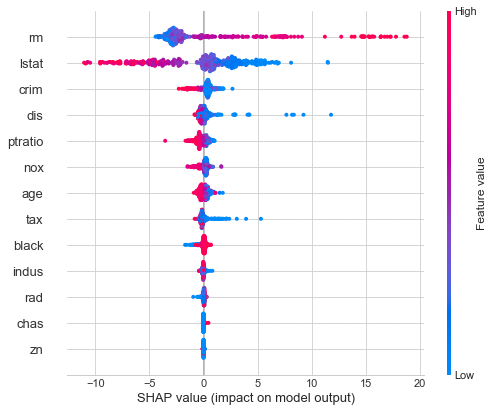

In [27]:
# Summarize the effects of all the features

shap.summary_plot(shap_values, X_train)

- The **plot** above **sorts features** by the **sum of SHAP value magnitudes over all samples**, and **uses SHAP values** to show the **distribution of the impacts each feature has on the model output**. 


- The **color represents the feature value (red high, blue low)**. 


- This **reveals** for example that a **high LSTAT** (% lower status of the population) **lowers the predicted home price**.

<a id=section706></a>
### 7.6 Bar chart of Mean Importance

- This takes the **average of the SHAP value magnitudes** across the dataset and **plots** it as a **simple bar chart**.

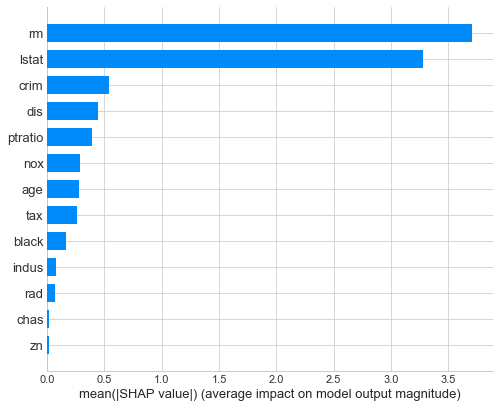

In [28]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

- Here we can see that the **rm** column has the **highest feature importance** followed by **lstat** column.


- This implies that the **number of rooms** and **lower status of the population** have the **highest** effect on the **price** of a **house** in **Boston**.